---
# Classificação de Demandas do Fala.BR
---
**Projeto do Bootcamp Machine Learning (Anderson Monteiro e Léo Maranhão de Mello)**

## Introdução



### **Descrição do projeto de machine learning**


**1- Descrição do problema ou tarefa:**
O problema consiste em classificar as demandas recebidas pela Ouvidoria da SUSEP, por meio do sistema Fala.BR.

**2- Descrição da solução de IA:**
Utilizaremos um processamento de NLP e testaremos modelos de regressão logística e Random Forest para classificação. A solução incluirá uma pipeline que realiza pré-processamento, treinamento e avaliação do modelo.

**3- Fonte de dados:**
A Ouvidoria forneceu um dataset com 1531 textos das demandas e suas classificações, no formato de planilha ODS. A classificação dos textos foi realizada pela própria Ouvidoria.

**4- Variáveis independentes (preditoras ou "features"):**
A variável independente é o texto recebido do Fala.BR.

**5- Variável dependente (resposta ou "target"):**
A variável dependente é a classificação do texto em uma das 17 classificações utilizadas pela Ouvidoria:

- Cadastro
- Capitalização
- Consulta Técnica
- DPVAT/SPVAT
- Não identificada
- Previdência Complementar Aberta
- Seguro Compreensivo
- Seguro de Automoveis
- Seguro de Crédito Interno
- Seguro de Danos
- Seguro de Pessoas
- Seguro de Responsabilidade
- Seguro de Transportes
- Seguro Fiança Locatícia
- Seguro Garantia
- Seguro Garantia Estendida
- Seguro Rural

In [41]:
# importar bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

!python -m spacy download pt_core_news_sm
import spacy

# Obtem os sinais de pontuação da língua portuguesa
import string

# instala módulo para ler ods
%pip install odfpy

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 58.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## 1- Carregar dados

In [22]:
# monta o goole drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# Carregar dados da planilha
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/bootcamp/dados/Projeto IA - Amostra Anonimizada - Demandas úteis da ouvidoria 2023.ods", engine="odf")

## 2- Análise exploratória dos dados

In [24]:
# Análise exploratória dos dados
df.head()

,Demanda,Tipo de Resposta,Categoria,Motivo
0,Preciso retirar minha responsabilidade técnica...,Corretores - cadastro,Cadastro,Documentação
1,Prezados.Venho através dessa denunciar a práti...,Mercado não supervisionado,Seguro de Automoveis,Denúncia sobre mercado não supervisionado
2,Quero saber sobre seguro de vida e apolices fe...,Cadastro de segurado,Seguro de Pessoas,Informações/dúvidas sobre produtos/serviços
3,"MUITO BOM DIA, estou recorrendo a este caminho...",Corretores - cadastro,Cadastro,Documentação
4,"Preciso, de uma verificação desta apólice! Apó...",Cadastro de segurado,Seguro de Pessoas,Informações/dúvidas sobre produtos/serviços


In [25]:
# Descreva a estatística básica da variáveis
df.describe()


,Demanda,Tipo de Resposta,Categoria,Motivo
count,1530,1530,1530,1530
unique,1522,15,17,46
top,Bom dia me chamo T gostaria de uma ajuda para ...,Reclamação - Consumidor.gov.br,Cadastro,Documentação
freq,2,460,470,450


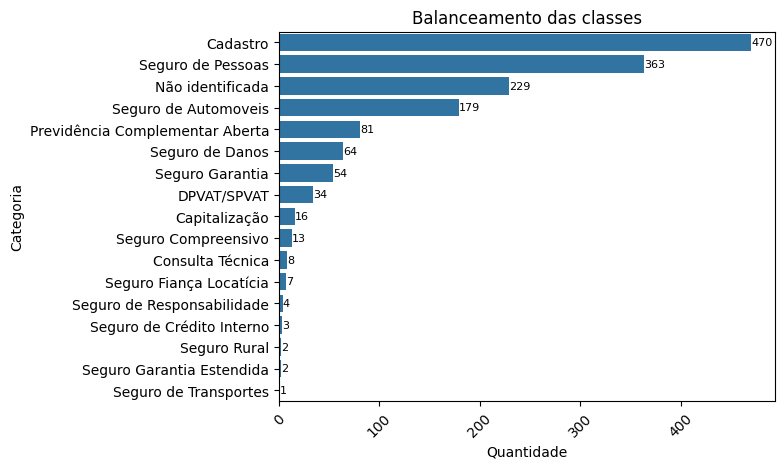

In [26]:
# Mostrar gráfico com o balanceamento das classes
ax = sns.countplot(y='Categoria', data=df, order=df['Categoria'].value_counts().index)
ax.bar_label(ax.containers[0], fontsize=8)
plt.xticks(rotation=45)
plt.title('Balanceamento das classes')
plt.xlabel('Quantidade')
plt.ylabel('Categoria')
plt.show()


In [27]:
# Seguro de transporte possui apenas uma ocorrência. Por outro lado, os seguros de Responsabilidade, Crédito Interno,
# Rural, Garantia Estendida também possuem poucos menos de 5 casos. Iremos criar uma nova categoria, Outros Seguros,
# juntando esses seguros de baixa ocorrência.
df['Categoria'] = df['Categoria'].replace(['Seguro de Transportes', 'Seguro de Responsabilidade', 'Seguro de Crédito Interno', 'Seguro Rural', 'Seguro Garantia Estendida'], 'Outros Seguros')


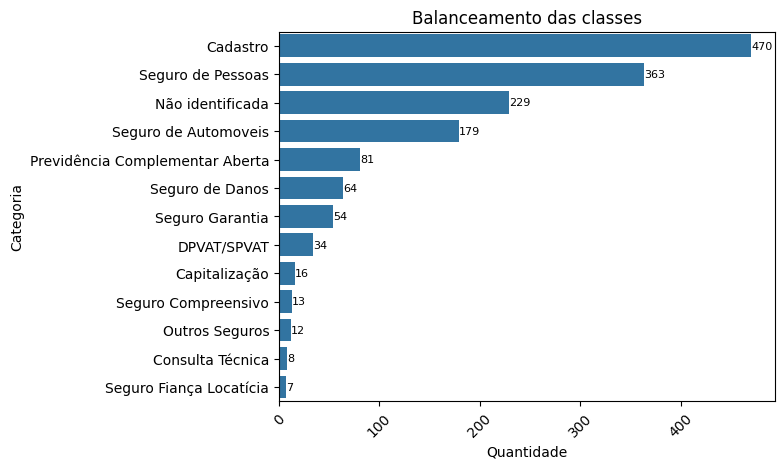

In [28]:
# Mostrar gráfico com o novo balanceamento das classes
ax = sns.countplot(y='Categoria', data=df, order=df['Categoria'].value_counts().index)
ax.bar_label(ax.containers[0], fontsize=8)
plt.xticks(rotation=45)
plt.title('Balanceamento das classes')
plt.xlabel('Quantidade')
plt.ylabel('Categoria')
plt.show()

In [29]:
# Bag of Words no sklearn: usamos CountVectorizer
# instancia o transform CountVectorizer
vectorizer = CountVectorizer()

# tokeniza e cria o vocabulário
vectorizer.fit(df['Demanda'])

# mostra o vocabulário criado
print('Vocabulário: ')
print(vectorizer.vocabulary_)

# converte em números
print('\ndimensões da matrix: ')
vector = vectorizer.transform(df['Demanda'])

# mostra as dimensões da matrix de frequência
print(vector.shape)

# mostra os documentos codificados
feature_names = vectorizer.get_feature_names_out()
df_bag = pd.DataFrame(vector.toarray(), columns = feature_names)

# Apresenta os totais das colunas, ordenando em ordem decrescente
df_bag.sum().sort_values(ascending=False)

Vocabulário: 
{'preciso': 8843, 'retirar': 10099, 'minha': 7410, 'responsabilidade': 10025, 'técnica': 11460, 'da': 3307, 'empresa': 4376, 'credenciada': 3156, 'na': 7630, 'susep': 10949, 'não': 7868, 'estou': 4844, 'conseguindo': 2790, 'prezados': 8985, 'venho': 11681, 'através': 1438, 'dessa': 3753, 'denunciar': 3531, 'prática': 9232, 'de': 3363, 'venda': 11659, 'ilegal': 5982, 'seguro': 10443, 'temos': 11101, 'em': 4293, 'americana': 889, 'um': 11489, 'grupo': 5785, 'chamado': 2213, 'motor': 7526, 'home': 5868, 'https': 5908, 'grupomotorhome': 5786, 'com': 2449, 'br': 1833, 'comercializando': 2471, 'proteção': 9182, 'veicular': 11629, 'como': 2496, 'se': 10367, 'fosse': 5472, 'unidade': 11503, 'fica': 5288, 'localizada': 7005, 'rua': 10250, 'são': 10993, 'gabriel': 5603, '333': 1, 'bairro': 1660, 'manoel': 7165, 'diante': 3881, 'do': 4090, 'fato': 5197, 'narrado': 7644, 'solicito': 10744, 'fiscalização': 5376, 'aplicação': 1064, 'das': 3347, 'leis': 6842, 'cabíveis': 1904, 'para': 8

,0
de,7249
que,4596
33,4363
do,2747
não,2591
...,...
federa,1
fechasse,1
fecharam,1
fechamos,1


## 3- Preparação dos dados

In [30]:
# Defina X e y
X = df['Demanda']
y = df['Categoria']

# respectivamente 4, 3, 2 e 2. Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [31]:
# Junta X_train e y_train em um novo dataset e grava como ods
df_train = pd.concat([X_train, y_train], axis=1)
df_train.to_excel("/content/drive/MyDrive/Colab Notebooks/bootcamp/dados/df_train.ods", engine="odf")

In [33]:
# Obtem as stopwords da língua portuguesa
stop_words = set(stopwords.words('portuguese'))


In [42]:
# Transforma X_train e X_test em minúsculas
X_train = X_train.str.lower()
X_test = X_test.str.lower()

# Retira as stop_words do X_train e X_test
X_train = X_train.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
X_test = X_test.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# Substituir os sinais de pontuação e números de X_train e X_test por espaço em branco
X_train = X_train.apply(lambda x: re.sub(u'[^a-zA-ZáéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ: ]', ' ', x))
X_test = X_test.apply(lambda x: re.sub(u'[^a-zA-ZáéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ: ]', ' ', x))

# Substituir os sinais de pontuação e números de X_train e X_test por espaço em branco
X_train = X_train.apply(lambda x: re.sub(' {2,}', ' ', x))
X_test = X_test.apply(lambda x: re.sub(' {2,}', ' ', x))

# Lemmatization de X_train e X_test
nlp = spacy.load("pt_core_news_sm")

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

X_train = X_train.apply(lemmatize_text)
X_test = X_test.apply(lemmatize_text)


## 4- Vizualização dos tokens após Preparação

In [43]:
# Bag of Words no sklearn: usamos CountVectorizer
# instancia o transform CountVectorizer
vectorizer = CountVectorizer()

# tokeniza e cria o vocabulário
vectorizer.fit(X_train)

# mostra o vocabulário criado
print('Vocabulário: ')
print(vectorizer.vocabulary_)

# converte em números
print('\ndimensões da matrix: ')
vector = vectorizer.transform(X_train)

# mostra as dimensões da matrix de frequência
print(vector.shape)

# mostra os documentos codificados
feature_names = vectorizer.get_feature_names_out()
df_bag_pos = pd.DataFrame(vector.toarray(), columns = feature_names)

# Apresenta os totais das colunas, ordenando em ordem decrescente
df_bag_pos.sum().sort_values(ascending=False)

Vocabulário: 
{'documento': 2517, 'encaminhar': 2745, 'dia': 2353, 'momento': 4869, 'susep': 7282, 'constar': 1694, 'sistema': 7062, 'suspender': 7295, 'precisar': 5802, 'agilidade': 219, 'ter': 7421, 'ver': 7779, 'precisamos': 5801, 'ativa': 709, 'comercializar': 1463, 'renovar': 6491, 'endossar': 2770, 'seguro': 6898, 'atenciosamente': 679, 'samir': 6801, 'maria': 4676, 'silva': 7025, 'possuo': 5748, 'auto': 785, 'zuric': 7989, 'apolice': 508, 'veiculo': 7748, 'colidir': 1441, 'outro': 5315, 'onde': 5235, 'condutor': 1610, 'assumir': 665, 'culpa': 1958, 'acidente': 87, 'abrir': 35, 'sinistro': 7052, 'sob': 7077, 'numero': 5122, 'segurar': 6895, 'terceiro': 7423, 'ocorrer': 5185, 'apo': 502, 'todo': 7475, 'processo': 5952, 'reguralação': 6426, 'sinsitro': 7055, 'seguradora': 6887, 'indentificar': 3937, 'perda': 5528, 'total': 7504, 'avaliar': 821, 'real': 6233, 'via': 7821, 'limite': 4481, 'maximo': 4716, 'indenização': 3932, 'contratar': 1781, 'dano': 2015, 'abertura': 19, 'sisnistro

,0
seguro,1693
dia,883
susep,788
seguradora,738
fazer,643
...,...
fusion,1
dirimir,1
dis,1
originada,1


## 5- Treinar o modelo

### Treino antes do SMOTE - SGDCClassifier sem GRIDSearchCV

In [44]:
# Define o pipeline incluindo: tokenização (TfidfVectorizer) e treinamento do classificador
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=4, max_features=50000,ngram_range=(1,2))),
    ('clf', SGDClassifier(loss='log_loss', penalty='elasticnet', alpha=1e-06)) # default hinge. to get proba=log or modified_huber
])


In [45]:
%%time
# Treine o modelo(fit)
classificador = pipeline.fit(X_train, y_train)


CPU times: user 434 ms, sys: 8.83 ms, total: 442 ms
Wall time: 456 ms


In [46]:
# Mostra a acurácia do modelo nos dados de teste
classificador.score(X_test, y_test)


0.7189542483660131

In [47]:
# Faça a predição nos dados de teste
y_pred = classificador.predict(X_test)


In [48]:
# Mostra o f1 score do modelo nos dados de teste (métrica usada quando as classes estão desbalanceadas)
f1_score(y_test, y_pred, average='macro')


0.4107810699773736

In [49]:
# avalie o modelo usando 'classification_report' do sklearn
print(classification_report(y_test, y_pred))


                                 precision    recall  f1-score   support

                       Cadastro       0.85      0.88      0.86        94
                  Capitalização       0.00      0.00      0.00         3
               Consulta Técnica       0.00      0.00      0.00         1
                    DPVAT/SPVAT       0.62      0.71      0.67         7
               Não identificada       0.44      0.39      0.41        46
                 Outros Seguros       0.00      0.00      0.00         2
Previdência Complementar Aberta       0.76      0.81      0.79        16
            Seguro Compreensivo       0.00      0.00      0.00         3
        Seguro Fiança Locatícia       0.00      0.00      0.00         1
                Seguro Garantia       0.67      0.73      0.70        11
           Seguro de Automoveis       0.72      0.72      0.72        36
                Seguro de Danos       0.33      0.38      0.36        13
              Seguro de Pessoas       0.82      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


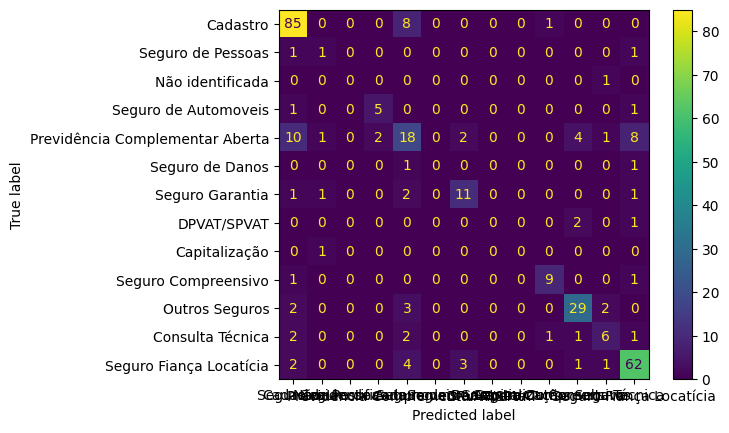

In [ ]:
# mostrar a matrix de confusão grafica do modelo sobre todo o dataset
ConfusionMatrixDisplay.from_estimator(classificador, X_test, y_test, values_format='d', display_labels=df['Categoria'].value_counts().index)


### Treino antes do SMOTE - RandomForestClassifier com GRIDSearchCV

In [ ]:
# Treinar o modelo
# Criar o pipeline com normalização e Random Forest
pipelineRF = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=1, max_features=50000,ngram_range=(1,2))),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Definir os hiperparâmetros para o Grid Search
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [2, 5]
}

# Realizar a busca de hiperparâmetros com validação cruzada
grid_search = GridSearchCV(pipelineRF, param_grid, cv=3, n_jobs=-1, scoring='f1')
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_model = grid_search.best_estimator_
print("Melhores hiperparâmetros:", grid_search.best_params_)

# Mostrar f1 score do melhor estimador
print("F1-Score: ", grid_search.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Melhores hiperparâmetros: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
F1-Score:  nan


### Busca exaustiva de hiperparâmetros

In [ ]:
# Definir os hiperparâmetros para o Grid Search
param_grid = {
    'classifier__n_estimators': [150, 200, 250],
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10]
}


# Realizar a busca de hiperparâmetros com validação cruzada
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, scoring='f1')
grid_search.fit(X_train, y_train)


# Melhor modelo encontrado
best_model = grid_search.best_estimator_
print("Melhor modelo encontrado:")
print(grid_search.best_estimator_)

# Mostrar f1 score do melhor estimador
print("F1 Score do melhor estimador:", grid_search.best_score_)


Melhor modelo encontrado:
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_split=5,
                                        n_estimators=150, random_state=42))])
F1 Score do melhor estimador: 0.9684869997990119


In [ ]:
# Definir os hiperparâmetros para o Grid Search
param_grid = {
    'classifier__n_estimators': [125, 150, 175],
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10]
}


# Realizar a busca de hiperparâmetros com validação cruzada
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, scoring='f1')
grid_search.fit(X_train, y_train)


# Melhor modelo encontrado
best_model = grid_search.best_estimator_
print("Melhor modelo encontrado:")
print(grid_search.best_estimator_)

# Mostrar f1 score do melhor estimador
print("F1 Score do melhor estimador:", grid_search.best_score_)


Melhor modelo encontrado:
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_split=5,
                                        n_estimators=150, random_state=42))])
F1 Score do melhor estimador: 0.9684869997990119


### Melhores hiperparâmetros:  
'classifier__max_depth' = ,  
'classifier__min_samples_split'=    
'classifier__n_estimators' =

## 5- Testar o modelo (inferência)

In [ ]:
# Testar o modelo (inferência)
y_pred = best_model.predict(X_test)


## 6- Avaliar o modelo

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        42
           1       0.96      0.96      0.96        72

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114

F1 Score: 0.9583333333333334


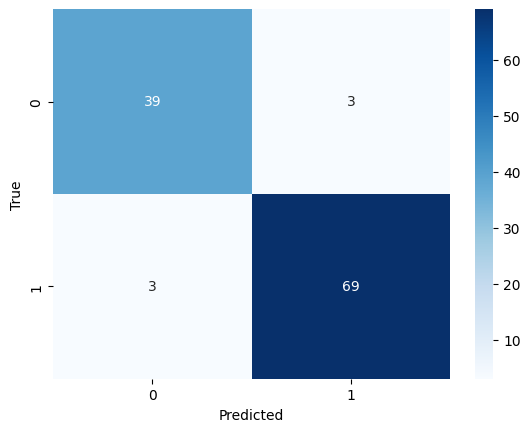

In [ ]:
# Avaliar o modelo
# Matriz de confusão grafica
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')


# Relatório de classificação
print(classification_report(y_test, y_pred))


# F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)


## 7- Salvar o modelo

In [ ]:
# Salvar o modelo
import joblib
joblib.dump(best_model, 'modelo_breast_cancer.pkl')


['modelo_breast_cancer.pkl']

In [ ]:
%ls -al


total 568
drwxr-xr-x 1 root root   4096 Oct 14 18:11 ./
drwxr-xr-x 1 root root   4096 Oct 14 17:46 ../
drwxr-xr-x 4 root root   4096 Oct 11 13:27 .config/
-rw-r--r-- 1 root root 562751 Oct 14 18:11 modelo_breast_cancer.pkl
drwxr-xr-x 1 root root   4096 Oct 11 13:27 sample_data/
